# Stacking Single-Source Heatmaps 

Instead of using an input array composed of a grid made up of multiple sources (with different intensities and positions) to predict the output heatmap array, here we will make a model that can predict the heatmap for a single source as a vector `[intensity,x,y]`  then stack (ie. add) the predictions from multiple individual sources to make a compound prediction for multiple sources.

The first step is to make a model that predicts the heatmap for a single source that works satisfactorally, then we combine multiple predictions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def generate_single_source_dataset(
    m, n, num_heatmaps=10, source_min=0,source_max=100,
    log_scale=False, min_element = 1):
    """Generates dataset of source matrices (location,intensity of sources) and 
    heatmap matrices (location, intensity due to all sources, obeying inverse-square law)
    PARAMETERS:
        m(int):              Number of rows in matrix (height)
        n(int):              Number of columns in matrix (width)
        num_heatmaps(int):   Number of heatmaps to generate
        source_min(numeric): Minimum intensity to draw random intensities from
        source_max(numeric): Maximum intensity to draw random intensities from
        log_scale(bool):     Whether heatmap intensity should be log scaled
        min_element(float):  If log_scale==True, replace intensities below this value with this value (avoids -inf)
    """
    xx,yy = np.meshgrid(np.arange(0, n), np.arange(0, m)) # grid of x,y values
    heatmap_matrices = np.zeros((num_heatmaps, m, n))
    source_vectors = np.zeros((num_heatmaps, 1,3))

    # make a bunch of random sources
    for i in range(num_heatmaps):
        source = create_random_source((source_min,source_max), m, n)
        intensity,x,y = source
        source_vectors[i] = np.array((intensity,x,y)).reshape(1,3)
        
        intensity_matrix = make_intensity_matrix(m,n,[source], xx, yy)                                                            

        if log_scale==True:
            heatmap_matrices[i] = log_scale_matrix(intensity_matrix, min_element)
        else:
            heatmap_matrices[i] = intensity_matrix    
    return source_vectors, heatmap_matrices


def create_random_source(i_lims=(0,100), x_max=10, y_max=10):
    """ Creates a tuple that represents a source with random x,y,intensity"""
    intensity = round(i_lims[0] + np.random.random()*(i_lims[1]-i_lims[0]),2)
    x = int(np.random.random()  * x_max)
    y = int(np.random.random() * y_max)
    return intensity, x ,y


def make_source_matrix(m,n, sources):
    """Makes a matrix that is 0 everywhere except where there is a source, where the value is the source intensity
        m x n is the output matrix size
        s is a list of 'sources' [[intensity_0, x_0, y_0],[intensity_1, x_1, y_1],...]
    """
    source_dist = np.zeros((m, n))
    for source in sources:
        intensity,x,y = source
        source_dist[int(y),int(x)] = intensity   

    return source_dist


def make_intensity_matrix(m,n,sources, xx=None, yy=None):
    """Creates a matrix representing"""
    # create meshgrid if one was not passed
    if xx is None:
        xx,yy = np.meshgrid(np.arange(0, n), np.arange(0, m)) # grid of x,y values
    intensity_matrix = np.zeros((m, n))
    
    for source in sources:
        intensity,x,y = source
        # calculate distance from every position in grid to source
        distances = np.sqrt((xx - x)**2 + (yy - y)**2) 
        # replace distance=0 with 1 to avoid div/0
        distances = np.where(distances==0, 1, distances) 
        # add intensity from source using inverse-square law
        intensity_matrix += intensity / distances**2   
    return intensity_matrix


def log_scale_matrix(matrix, min_element=1):
    """Transforms matrix values by taking log of each element. 
    Replaces small values to avoid -inf when taking log
    """
    matrix = np.where(matrix<min_element, min_element, matrix)
    return np.log(matrix) 


def inverse_log_scale_matrix(matrix, min_element=1):
    """performs inverse transformation to `log_scale_matrix()` """
    matrix = np.exp(matrix) 
    return np.where(matrix==min_element, 0, matrix)


def plot_heatmap(data, title = "", height = 3, cmap="viridis", norm="linear"):  
    """plots a heatmap with colorbar"""
    plt.figure(figsize=(height,height))
    img = plt.imshow(data, cmap=cmap, interpolation='nearest', norm=norm)
    plt.gca().invert_yaxis()
    plt.colorbar(img,fraction=0.046, pad=0.04)
    plt.title(title)
    plt.tight_layout()
    return

In [3]:
def plot_source_intensity_heatmaps(sources, intensity, height = 3, cmap = "plasma"):
    fig, axes = plt.subplots(1, 2, figsize=(2*height, height))

    # Plot original heatmap
    im0 = axes[0].imshow(sources, cmap=cmap, origin='lower')
    axes[0].set_title("Source")
    fig.colorbar(im0, ax=axes[0],fraction=0.046, pad=0.04)

    # Plot original heatmap
    im1 = axes[1].imshow(intensity, cmap=cmap, origin='lower')
    axes[1].set_title("Simulated Intensity")
    fig.colorbar(im1, ax=axes[1],fraction=0.046, pad=0.04)

    
    plt.tight_layout()
    plt.show()
    return

# Make dataset of single sources

In [4]:
heatmap_w, heatmap_h = 32, 32
n_sources=1
num_heatmaps = 10000
source_min = 100
source_max = 1000
log_scale = False
min_element = None


Xs, Ys = generate_single_source_dataset(heatmap_h, heatmap_w, num_heatmaps, source_min, source_max)

4451


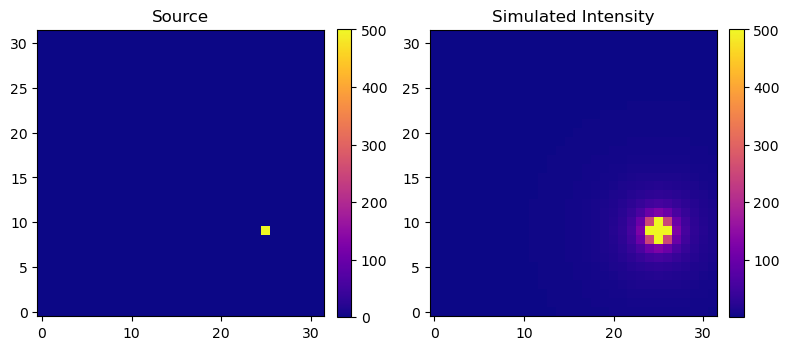

In [5]:
# Look at a sample (re-run to get another sample)
idx = np.random.randint(Xs.shape[0])
print(idx)
source = make_source_matrix(heatmap_h, heatmap_w, [Xs[idx].reshape(3,)])
plot_source_intensity_heatmaps(source, Ys[idx], height=4)

# Make model to predict single source heatmap

In [6]:
import keras
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Identity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras import activations
from tensorflow.keras.initializers import GlorotUniform
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LeakyReLU

def build_model_leaky(n_inputs, hidden_layers=[10, 10, 10], n_out=1, dropout=0., alpha=0.3):
    """
    builds a neural network using the depth and layer sizes provided by hidden_layers arg
    choose an activation function from the supported functions in activations
    
    when Keras initializes the weights and biases, they're set to random values, this can 
    cause each instance of the model to perform radically differently 
    
    As such, when we compare the results for different epochs, normalization, etc. the 
    weights and biases should be set using the same seed and initializer
    """
    initializer = GlorotUniform(seed=808)
    
    model = Sequential()
    for i, layer in enumerate(hidden_layers):
        if i == 0:
            # define the input shape based on n_inputs
            model.add(Dense(hidden_layers[i], input_shape=(n_inputs,), kernel_initializer=initializer))
            model.add(LeakyReLU(alpha = alpha))
            # model.add(Identity())
        else:
            model.add(Dropout(dropout))
            model.add(BatchNormalization())
            # base the input shape on the previous layer
            model.add(Dense(hidden_layers[i], input_shape=(hidden_layers[i-1],), kernel_initializer=initializer))
            model.add(LeakyReLU(alpha = alpha))
            # model.add(Identity())
    
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    # add our output layer
    model.add(Dense(n_out, input_shape=(hidden_layers[len(hidden_layers)-1],), kernel_initializer=initializer))
    
    # build the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [7]:
def plot_compare_heatmaps(actual, predicted, height = 3):
    fig, axes = plt.subplots(1, 2, figsize=(3*height, height))
    
    # set colorscale max and min
    min_i = max(actual.min(), predicted.min()) 
    max_i = max(actual.max(), predicted.max()) 
    
    # Plot actual heatmap
    im1 = axes[0].imshow(actual, cmap='plasma', origin='lower')
    axes[0].set_title("Target heatmap")
    fig.colorbar(im1, ax=axes[0],fraction=0.046, pad=0.04) 
    im1.set_clim(vmin=min_i, vmax=max_i)

    # Plot predicted heatmap
    im2 = axes[1].imshow(predicted, cmap='plasma', origin='lower')
    axes[1].set_title("Predicted heatmap")
    fig.colorbar(im2, ax=axes[1],fraction=0.046, pad=0.04) 
    im2.set_clim(vmin=min_i, vmax=max_i)

    plt.tight_layout()
    plt.show()

In [8]:
# make dataset
heatmap_w, heatmap_h = 32, 32
n_sources=1
num_heatmaps = 50000
source_min = 100
source_max = 1000

Xs, Ys = generate_single_source_dataset(heatmap_h, heatmap_w, num_heatmaps, source_min, source_max)

Xs_reshaped = Xs.reshape((num_heatmaps, 3))
ys_reshaped = Ys.reshape((num_heatmaps, heatmap_w*heatmap_h))
X_train, X_test, y_train, y_test = train_test_split(Xs_reshaped, ys_reshaped, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(40000, 3) (40000, 1024)
(10000, 3) (10000, 1024)


In [9]:
n_epochs = 100
hidden_layers = [2048,2048,2048,2048]

batch_size = 512 
alpha = 0.2

best_model_name = 'best_single_source_model.h5'

# saving the best model weights
checkpoint = ModelCheckpoint(best_model_name, 
    verbose=0, 
    monitor='val_loss',
    save_best_only=True, 
    mode='min'
)  

# build the model
model = build_model_leaky(X_train.shape[1], hidden_layers, n_out=heatmap_w*heatmap_h, alpha=alpha)

# fit the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=n_epochs, 
                    batch_size=batch_size, 
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/100
78/79 [============================>.] - ETA: 0s - loss: 2111.0708 - mean_squared_error: 2111.0708

/Users/trevorkinsey/opt/miniconda3/envs/ml2/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


79/79 [==============================] - 12s 145ms/step - loss: 2111.0479 - mean_squared_error: 2111.0479 - val_loss: 2612.0994 - val_mean_squared_error: 2612.0994
Epoch 2/100
79/79 [==============================] - 11s 140ms/step - loss: 1754.0344 - mean_squared_error: 1754.0344 - val_loss: 2178.9360 - val_mean_squared_error: 2178.9360
Epoch 3/100
79/79 [==============================] - 11s 139ms/step - loss: 1563.0059 - mean_squared_error: 1563.0059 - val_loss: 2937.9612 - val_mean_squared_error: 2937.9612
Epoch 4/100
79/79 [==============================] - 11s 140ms/step - loss: 1430.9404 - mean_squared_error: 1430.9404 - val_loss: 2257.3987 - val_mean_squared_error: 2257.3987
Epoch 5/100
79/79 [==============================] - 11s 141ms/step - loss: 1318.9944 - mean_squared_error: 1318.9944 - val_loss: 1758.7040 - val_mean_squared_error: 1758.7040
Epoch 6/100
79/79 [==============================] - 11s 139ms/step - loss: 1234.4008 - mean_squared_error: 1234.4008 - val_loss: 22

In [10]:
# # load saved model to avoid re-training
# best_model_name = 'best_single_source_model.h5'
# model = keras.models.load_model(best_model_name)
# model.summary()

In [11]:
preds = model.predict(X_test)

313/313 [==============================] - 2s 7ms/step


sample #5510  RMSE = 15.29
   source:    (x,y)=(28, 5), intesity=485.37
   predicted: (x,y)=(28, 5), intesity=357.0


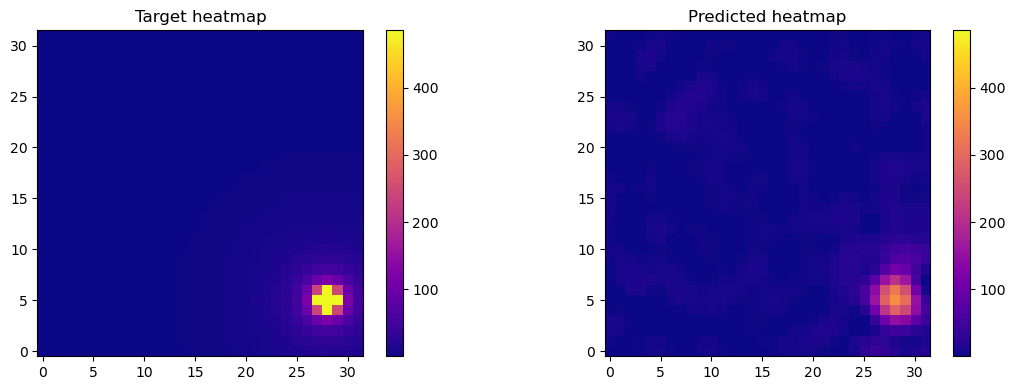

In [12]:
# pick random sample to examine
idx = np.random.randint(y_test.shape[0])
    
predicted = preds[idx].reshape((heatmap_w,heatmap_h))

# calculate RMSE
rmse = np.sqrt((np.square(preds[idx] - y_test[idx])).mean())
print(f"sample #{idx}  RMSE = {round(rmse,2)}")

i,x,y = X_test[idx]
print(f"   source:    (x,y)={round(x),round(y)}, intesity={i}")
y,x = np.unravel_index(predicted.argmax(), predicted.shape)
print(f"   predicted: (x,y)={(x,y)}, intesity={np.round(predicted.max())}")

plot_compare_heatmaps(y_test[idx].reshape((heatmap_w, heatmap_h)), predicted, height = 4)

**Notes:** Well this kinda works in that the position of the source fairly accurate, but the intensity is not.

It doesn't take long for the model to learn to identify the source location, but need more iterations and more training examples to identify the intensity of the source

# Stack multiple single-source predictions
This allows us to make a prediction for multiple sources. Each source is an X, each prediction is a y

In [17]:
# generate random sources
num_random_sources = 8
test_sources = []
source_min=250

for _ in range(num_random_sources):
    test_sources.append(create_random_source((source_min,source_max), heatmap_w, heatmap_h))
    
test_sources

[(676.49, 31, 7),
 (940.94, 0, 31),
 (412.29, 0, 2),
 (993.02, 17, 19),
 (468.69, 27, 23),
 (648.01, 28, 11),
 (528.81, 1, 18),
 (324.63, 8, 1)]

1 sources, RMSE = 23.26


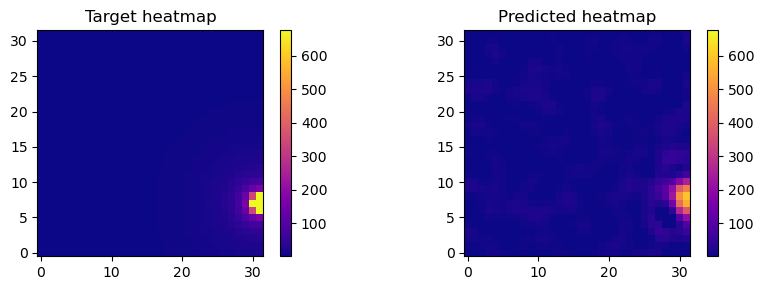

2 sources, RMSE = 37.69


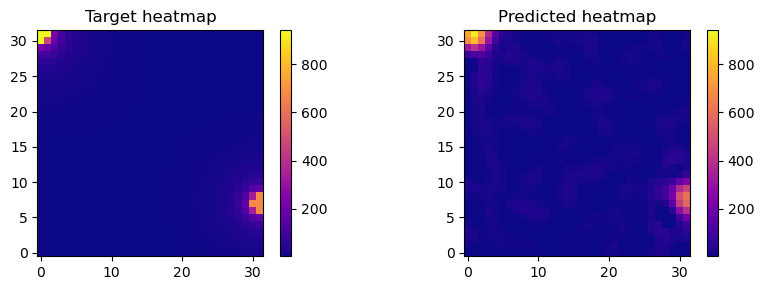

3 sources, RMSE = 39.36


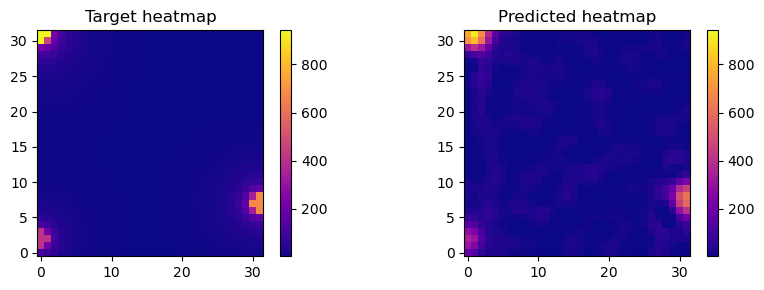

4 sources, RMSE = 52.43


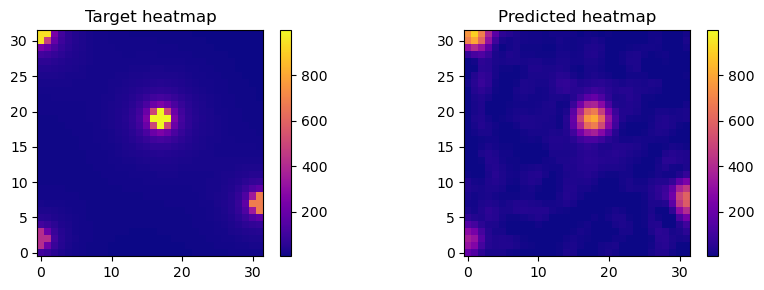

5 sources, RMSE = 53.88


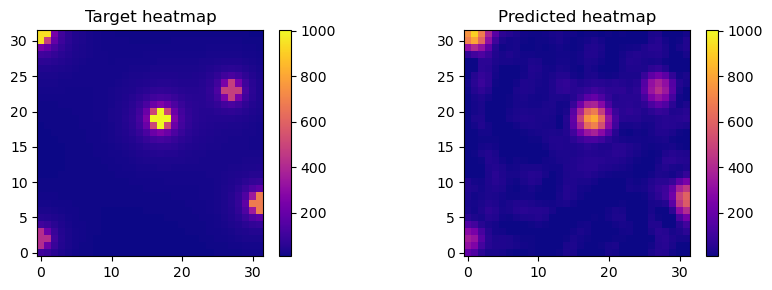

6 sources, RMSE = 58.01


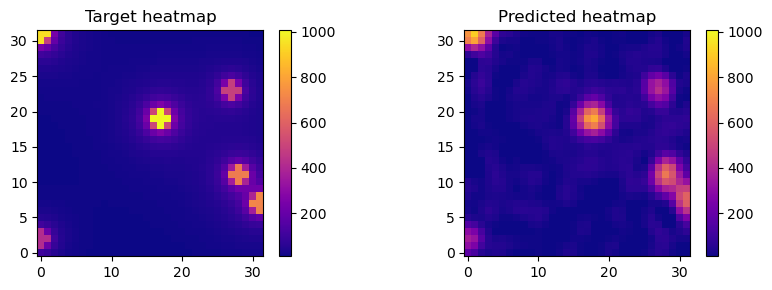

7 sources, RMSE = 61.52


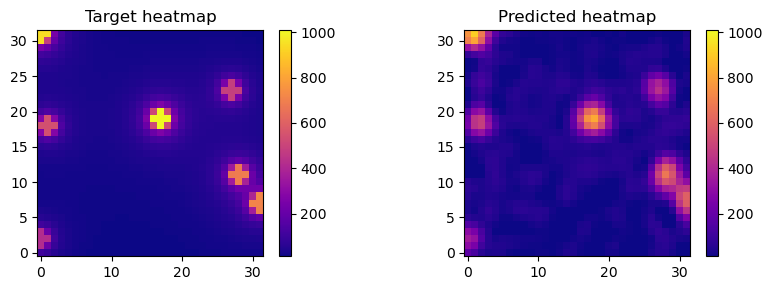

8 sources, RMSE = 62.33


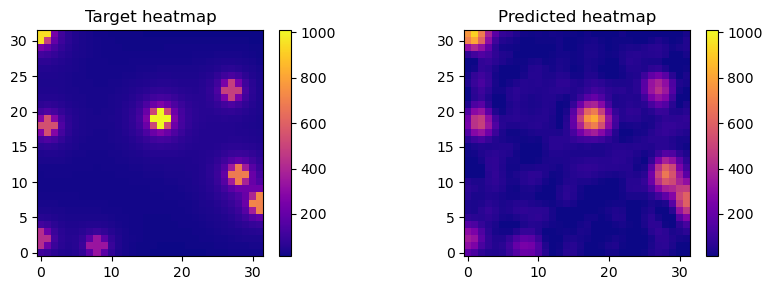

In [18]:
for num_sources in range(1,num_random_sources+1):
    
    # select subset from predefined sources
    sources = test_sources[0:num_sources]
    sources_matrix = make_source_matrix(heatmap_h,heatmap_w, sources)
    
    # use sources to make intensity heatmap
    target_heatmap = make_intensity_matrix(heatmap_h,heatmap_w,sources)
    
    # predict heatmap for every single source
    preds = model.predict(sources, verbose = 0) 

    # add predictions from each source
    stacked_heatmap = np.zeros((heatmap_w, heatmap_h))
    for pred in preds:
        stacked_heatmap+=pred.reshape((heatmap_w, heatmap_h))
        
    
    rmse = np.sqrt((np.square(target_heatmap - stacked_heatmap).mean()))
    print(f"{num_sources} sources, RMSE = {round(rmse,2)}")

    plot_compare_heatmaps(target_heatmap, stacked_heatmap)

**Notes:** This also kinda works in that the pattern of sources is reproduced, but the intensity is still not correct and nearby source get merged together.
